In [1]:
%pip install plotly

/Users/roman/Workspace/maestria/maestria-ia/indexador-py/.venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [3]:
data_dir = "../data/"
file_name = "aptos_bogota.csv"
file_path = Path(f"{data_dir}/{file_name}")

if not file_path.is_file():
    raise Exception("No existe el archivo de datos, ejecute el notebook 1.download_csv.ipynb")

df = pd.read_csv(file_path)


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28578 entries, 0 to 28577
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   precio_venta      28578 non-null  float64
 1   area              28578 non-null  float64
 2   habitaciones      28578 non-null  float64
 3   banos             28578 non-null  float64
 4   administracion    26006 non-null  float64
 5   parqueaderos      28578 non-null  float64
 6   sector            27128 non-null  object 
 7   estrato           28576 non-null  float64
 8   antiguedad        28568 non-null  object 
 9   latitud           27881 non-null  float64
 10  longitud          27881 non-null  float64
 11  estado            27835 non-null  object 
 12  alarma            28578 non-null  int64  
 13  ascensor          28578 non-null  int64  
 14  conjunto_cerrado  28578 non-null  int64  
 15  gimnasio          28578 non-null  int64  
 16  piscina           28578 non-null  int64 

In [5]:
# descripción general
print(df.describe())

       precio_venta          area  habitaciones         banos  administracion  \
count  2.857800e+04  28578.000000  28578.000000  28578.000000    2.600600e+04   
mean   2.317387e+09    142.847903      2.747918      2.831199    5.451693e+06   
std    5.476481e+10    230.962515      0.781518      1.165875    7.831407e+07   
min    7.900000e+05      0.000000      1.000000      0.000000    1.000000e+00   
25%    4.100000e+08     69.000000      2.000000      2.000000    3.500000e+05   
50%    7.000000e+08    110.000000      3.000000      3.000000    6.500000e+05   
75%    1.320000e+09    180.000000      3.000000      4.000000    1.190000e+06   
max    4.250000e+12  19621.000000      7.000000      6.000000    3.500000e+09   

       parqueaderos       estrato       latitud      longitud        alarma  \
count  28578.000000  28576.000000  27881.000000  27881.000000  28578.000000   
mean       1.758591      4.860652      4.685286    -74.057095      0.056792   
std        1.088059      1.215691

In [6]:
print("\nValores nulos por columna:\n", df.isnull().mean().sort_values(ascending=False) * 100)


Valores nulos por columna:
 area_terraza        74.588845
numero_closets      63.492897
numero_piso         31.902163
administracion       8.999930
sector               5.073833
estado               2.599902
latitud              2.438939
longitud             2.438939
antiguedad           0.034992
estrato              0.006998
area                 0.000000
parqueaderos         0.000000
alarma               0.000000
ascensor             0.000000
conjunto_cerrado     0.000000
gimnasio             0.000000
piscina              0.000000
zona_de_bbq          0.000000
banos                0.000000
habitaciones         0.000000
precio_venta         0.000000
dtype: float64


*Conclusiones preliminares de la exploración*

La revisión inicial de los datos revela varios aspectos importantes a considerar antes de proceder con la imputación y el modelado. Se identificaron valores erróneos o sospechosos en variables clave como area (con mínimos en 0 y máximos extremadamente altos), parqueaderos (valores negativos), estrato (valores en 0, fuera del rango esperado) y numero_piso (valores imposibles mayores a 2,000). También se detectaron coordenadas (latitud y longitud) fuera de los rangos geográficos plausibles para Bogotá.

En cuanto a las variables binarias (alarma, piscina, gimnasio, zona_de_bbq), presentan un fuerte desbalance con predominio de ceros, indicando que estas características son poco frecuentes en la muestra. Variables categóricas como sector, estado y antiguedad también requieren un análisis detallado para identificar categorías raras o inconsistentes.

Finalmente, se observa un porcentaje moderado de valores faltantes en algunas variables (administracion, latitud, longitud, sector, estado) y un alto nivel de ausencia en area_terraza, numero_piso y numero_closets, que requerirá estrategias específicas de manejo o descarte según su relevancia.

En resumen, los datos contienen errores, outliers y desbalances importantes que deben ser tratados para garantizar la calidad del análisis y la robustez de los modelos predictivos.

In [7]:
# --- Variables numéricas sospechosas ---
cols_numericas = ['area', 'precio_venta', 'parqueaderos', 'estrato', 'numero_piso']
for col in cols_numericas:
    print(f"\nValores únicos y extremos en {col}:")
    print(df[col].describe())
    print(df[col].value_counts().head(10))



Valores únicos y extremos en area:
count    28578.000000
mean       142.847903
std        230.962515
min          0.000000
25%         69.000000
50%        110.000000
75%        180.000000
max      19621.000000
Name: area, dtype: float64
area
90.0     302
80.0     290
60.0     281
70.0     268
50.0     252
120.0    228
100.0    225
150.0    225
45.0     224
55.0     221
Name: count, dtype: int64

Valores únicos y extremos en precio_venta:
count    2.857800e+04
mean     2.317387e+09
std      5.476481e+10
min      7.900000e+05
25%      4.100000e+08
50%      7.000000e+08
75%      1.320000e+09
max      4.250000e+12
Name: precio_venta, dtype: float64
precio_venta
1.200000e+09    418
1.100000e+09    394
6.500000e+08    364
1.300000e+09    353
7.500000e+08    345
8.500000e+08    339
5.500000e+08    339
4.500000e+08    333
1.400000e+09    277
1.800000e+09    261
Name: count, dtype: int64

Valores únicos y extremos en parqueaderos:
count    28578.000000
mean         1.758591
std          1.088

## Area y precio de venta

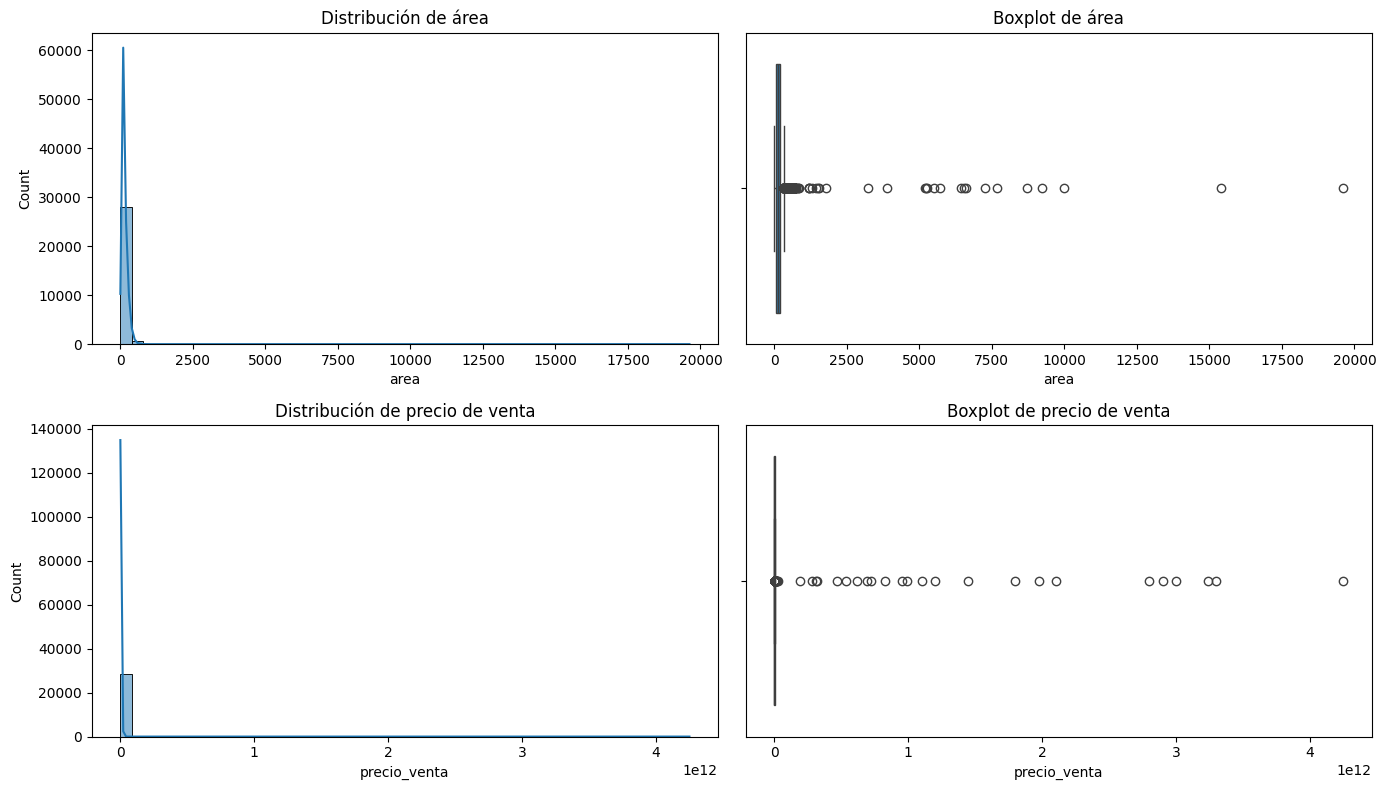

In [16]:
# --- Distribuciones univariantes en 2x2 ---

def plot_area_precio(dataframe):
    fig, axes = plt.subplots(2, 2, figsize=(14,8))

    # Histograma área
    sns.histplot(dataframe['area'], bins=50, kde=True, ax=axes[0,0])
    axes[0,0].set_title("Distribución de área")

    # Boxplot área
    sns.boxplot(x=dataframe['area'], ax=axes[0,1])
    axes[0,1].set_title("Boxplot de área")

    # Histograma precio_venta
    sns.histplot(dataframe['precio_venta'], bins=50, kde=True, ax=axes[1,0])
    axes[1,0].set_title("Distribución de precio de venta")

    # Boxplot precio_venta
    sns.boxplot(x=dataframe['precio_venta'], ax=axes[1,1])
    axes[1,1].set_title("Boxplot de precio de venta")

    plt.tight_layout()
    plt.show()

plot_area_precio(df)

En las variables área y precio de venta se evidencian valores expremos que distorsionan las distribuciones, se eliminarán usando un umbral.

In [9]:
# Calcular umbrales usando el percentil 99
area_umbral = df['area'].quantile(0.99)
precio_umbral = df['precio_venta'].quantile(0.99)

print(f"Umbral área (99%): {area_umbral}")
print(f"Umbral precio_venta (99%): {precio_umbral}")

Umbral área (99%): 464.0
Umbral precio_venta (99%): 5400000000.0


In [10]:
# Filtrar datos sin outliers extremos
df_clean = df[(df['area'] <= area_umbral) & (df['precio_venta'] <= precio_umbral)]

print(f"Datos originales: {df.shape[0]}, después de filtrar: {df_clean.shape[0]}")

Datos originales: 28578, después de filtrar: 28109


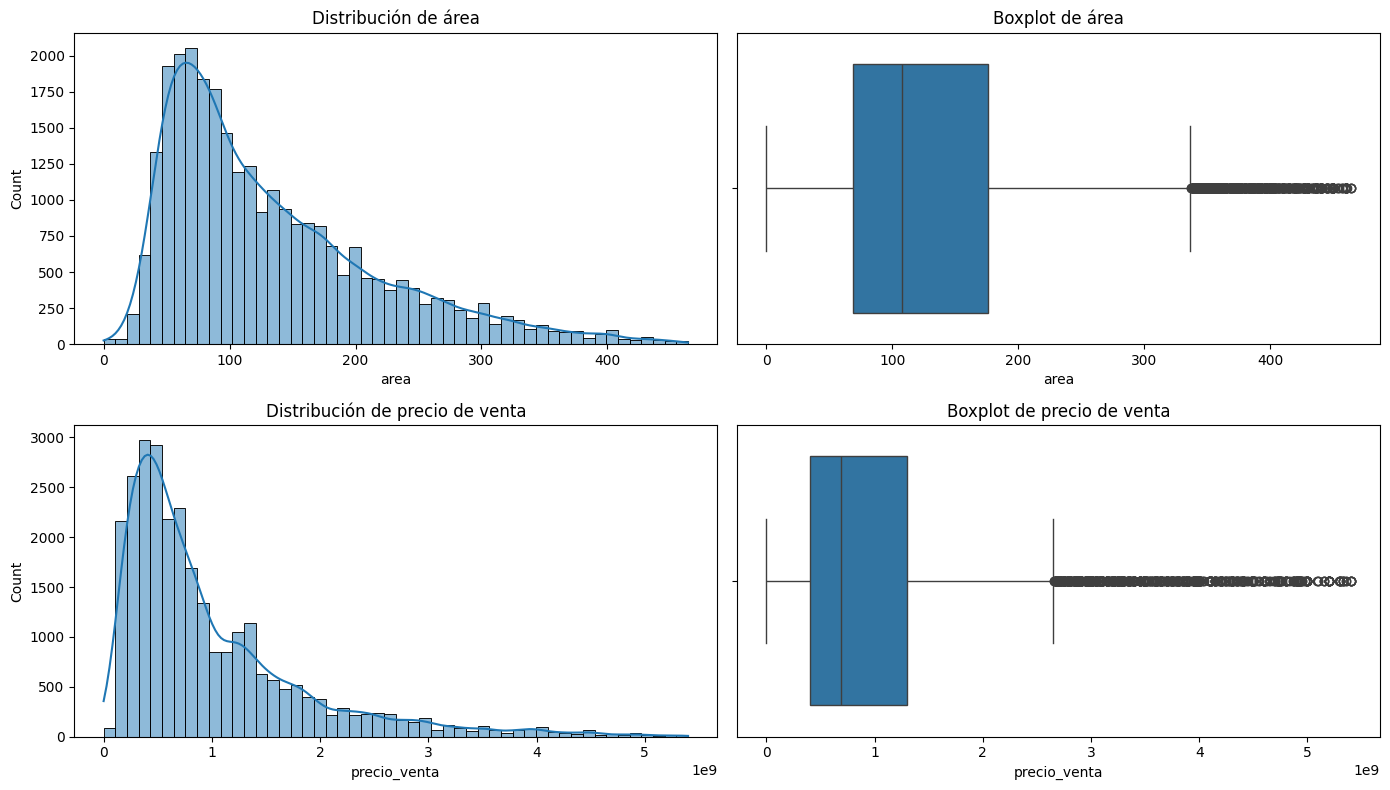

In [11]:
plot_area_precio(df_clean)

Luego de la limpieza, los datos presentan mejores distribuciones:

* El histograma de area muestra un pico en torno a 50–100 m², coherente con apartamentos típicos.
* El histograma de precio_venta ahora deja ver mejor la moda y la cola larga.


En el modelado, considerar aplicar logaritmo a precio_venta y/o area para reducir asimetría y mejorar linealidad.

## Estrato, sector, estado y antigüedad

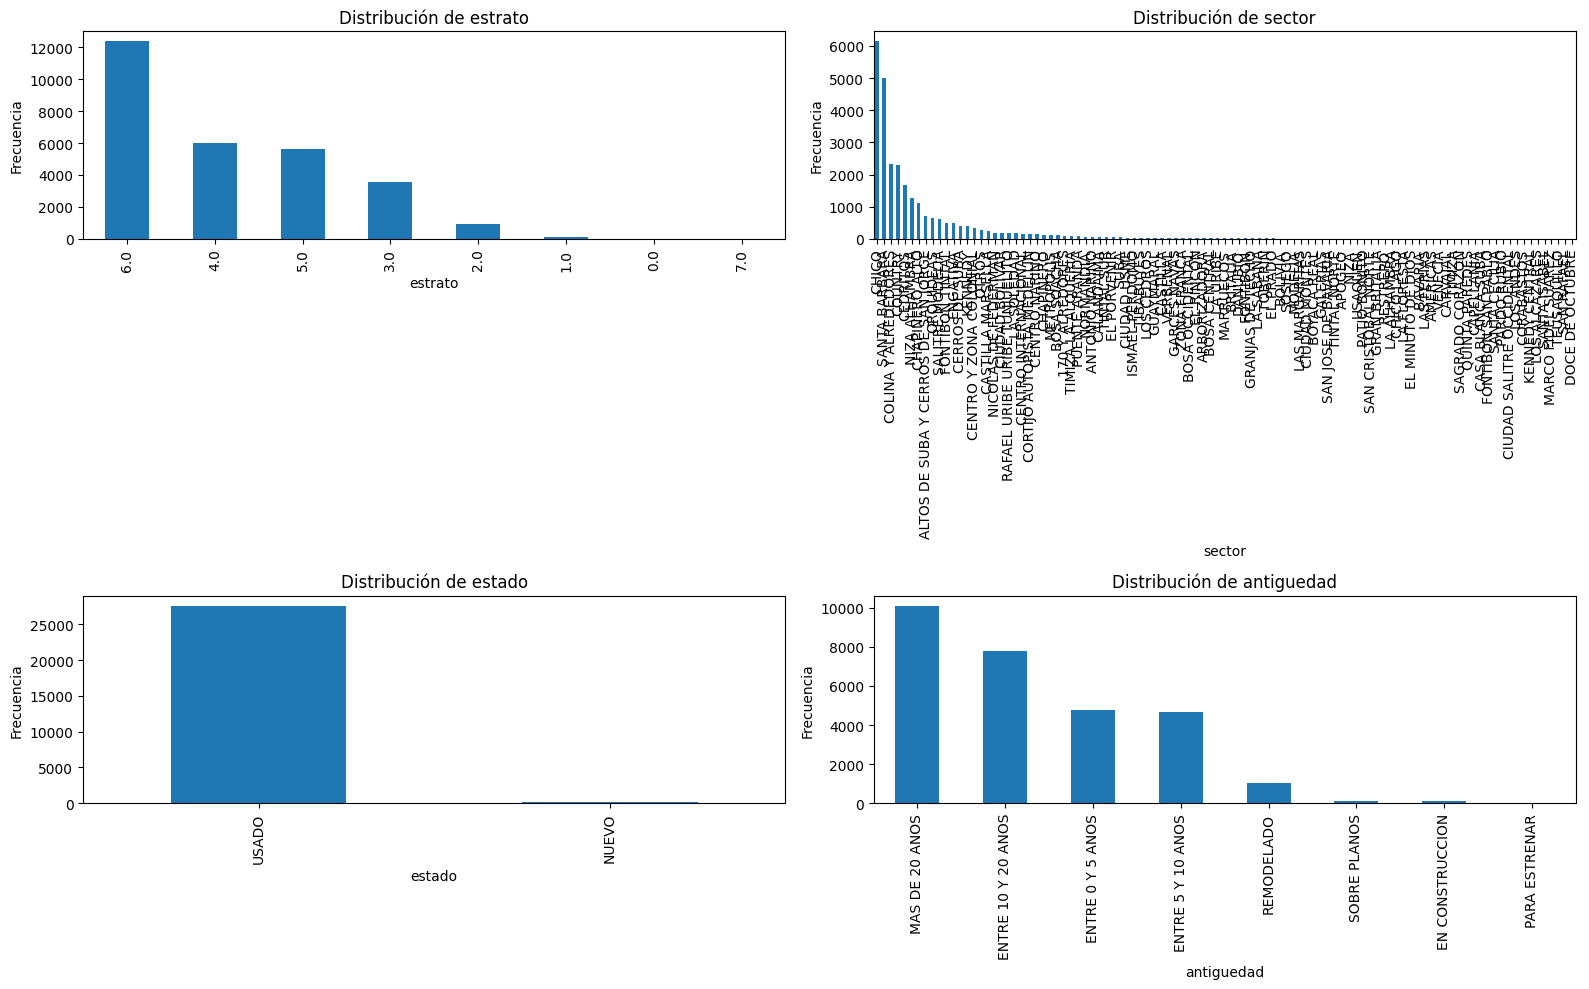

In [12]:
# --- Distribución de variables categóricas ---
cat_vars = ['estrato', 'sector', 'estado', 'antiguedad']

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for ax, col in zip(axes.flatten(), cat_vars):
    df[col].value_counts().plot(kind='bar', ax=ax)
    ax.set_title(f"Distribución de {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()


El estrato tiene algunos valores invalidos que pueden ser inputados luego, sin embargo esta característica puede calcularse automáticamente a partir del mapa.

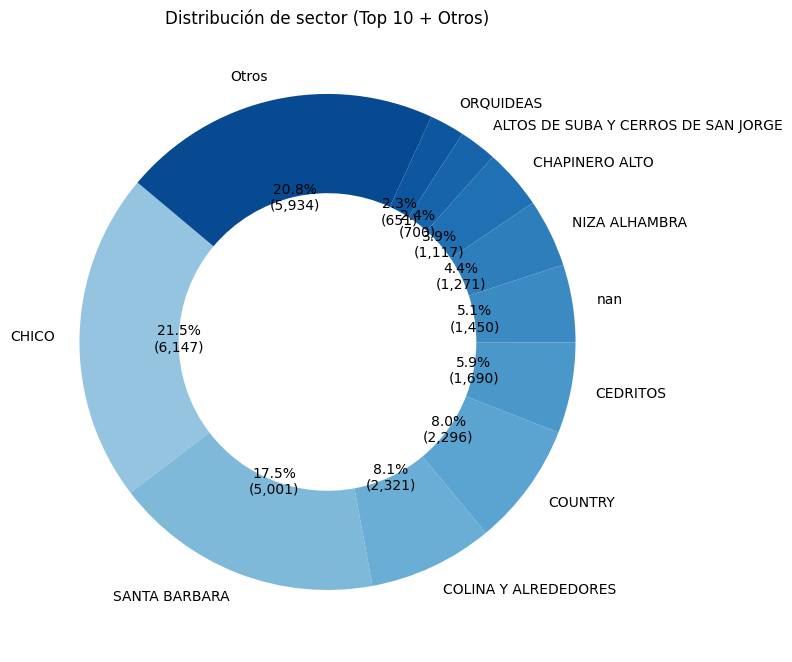

In [14]:
import numpy as np

counts = df['sector'].value_counts(dropna=False)
top_n = 10
top = counts.iloc[:top_n]
other = counts.iloc[top_n:].sum()

if other > 0:
    plot_counts = pd.concat([top, pd.Series({'Otros': other})])
else:
    plot_counts = top

fig, ax = plt.subplots(figsize=(8, 8))
colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(plot_counts)))

wedges, texts, autotexts = ax.pie(
    plot_counts.values,
    labels=plot_counts.index.astype(str),
    autopct=lambda p: f'{p:.1f}%\n({int(round(p/100*plot_counts.sum())):,})',
    startangle=140,
    colors=colors,
    wedgeprops=dict(width=0.4)  # donut
)

ax.set_title('Distribución de sector (Top 10 + Otros)')
plt.tight_layout()
plt.show()

## Variables binarias (Caracteristicas)

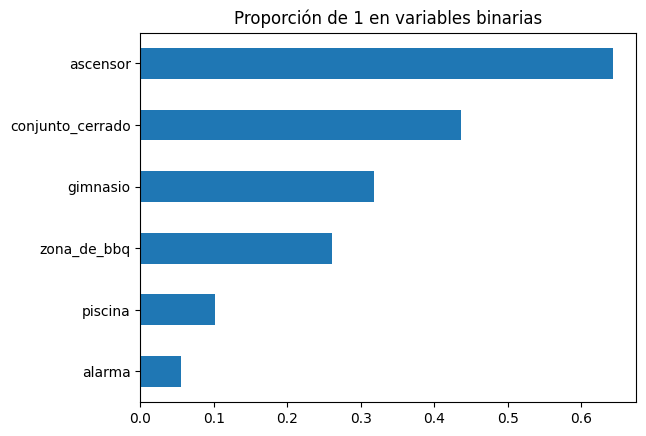

In [15]:

# --- 📊 Variables binarias ---
binarias = ['alarma', 'ascensor', 'conjunto_cerrado', 'gimnasio', 'piscina', 'zona_de_bbq']
df_clean[binarias].mean().sort_values().plot(kind='barh')
plt.title("Proporción de 1 en variables binarias")
plt.show()


* Ascensor y conjunto cerrado probablemente son buenos predictores porque tienen bastante variabilidad y frecuencia suficiente.
* Piscina y alarma tienen muy pocas ocurrencias → podrían tener poco peso en el modelo y ser candidatos para agruparse, eliminarse, o simplemente reportar como “amenidades raras”.

=== Distribución original de sectores ===


,Frecuencia,Porcentaje
sector,,
CHICO,6147,21.51
SANTA BARBARA,5001,17.50
COLINA Y ALREDEDORES,2321,8.12
COUNTRY,2296,8.03
CEDRITOS,1690,5.91
NIZA ALHAMBRA,1271,4.45
CHAPINERO ALTO,1117,3.91
ALTOS DE SUBA Y CERROS DE SAN JORGE,700,2.45
ORQUIDEAS,651,2.28


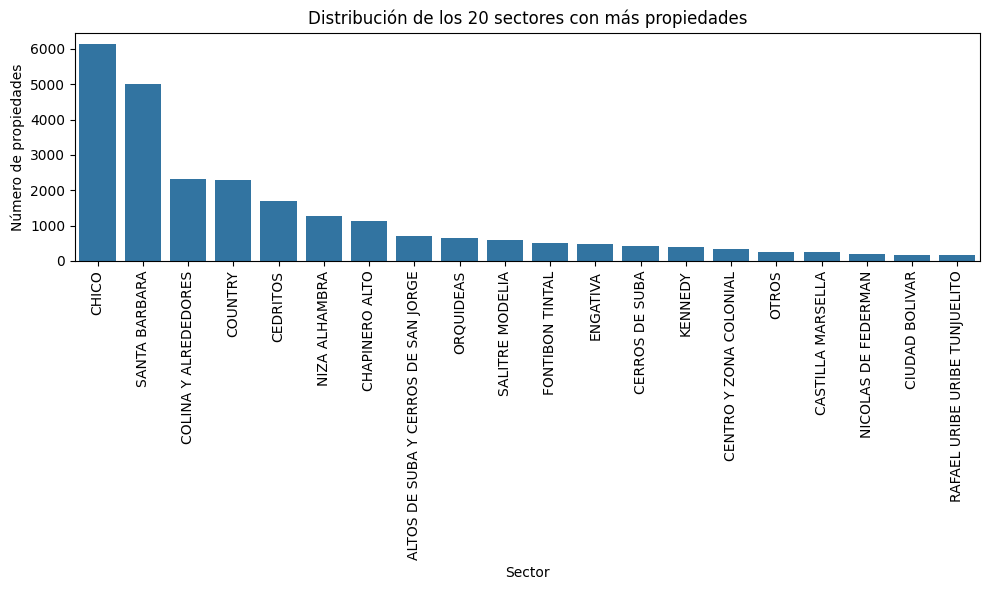


=== Distribución de sectores en dataset transformado ===


,Frecuencia,Porcentaje
sector,,
CHICO,6147,21.51
SANTA BARBARA,5001,17.50
COLINA Y ALREDEDORES,2321,8.12
COUNTRY,2296,8.03
CEDRITOS,1690,5.91
NIZA ALHAMBRA,1271,4.45
CHAPINERO ALTO,1117,3.91
ALTOS DE SUBA Y CERROS DE SAN JORGE,700,2.45
ORQUIDEAS,651,2.28


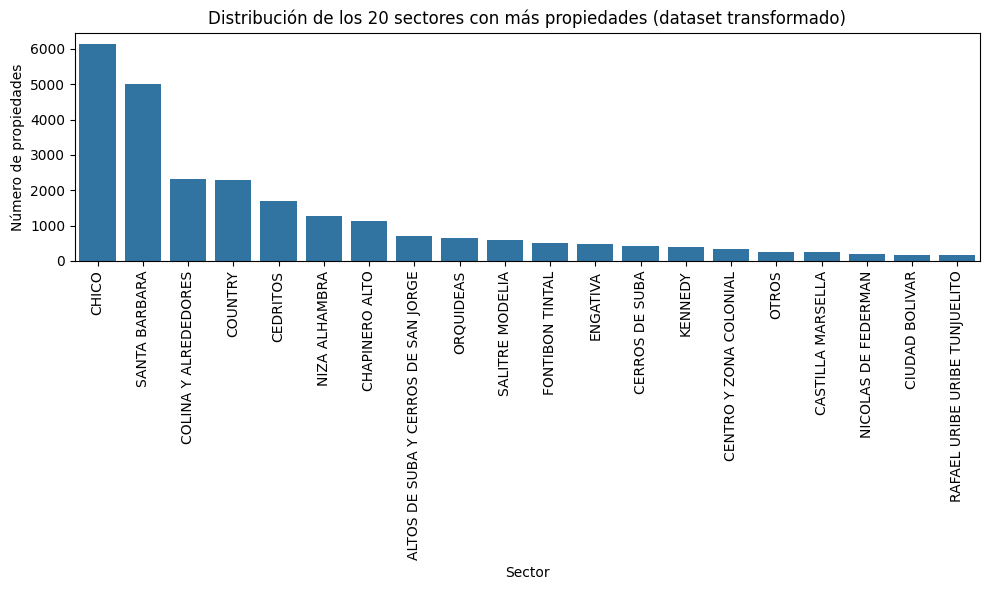

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Distribución original de sectores ===
sector_counts = df['sector'].value_counts()
sector_percent = (sector_counts / len(df)) * 100

# Tabla resumen
summary = pd.DataFrame({
    'Frecuencia': sector_counts,
    'Porcentaje': sector_percent.round(2)
})
print("=== Distribución original de sectores ===")
display(summary.head(20))  # muestra los 20 más frecuentes

# Gráfico: Top 20 sectores
plt.figure(figsize=(10,6))
sns.barplot(x=sector_counts.head(20).index, y=sector_counts.head(20).values)
plt.title('Distribución de los 20 sectores con más propiedades')
plt.xlabel('Sector')
plt.ylabel('Número de propiedades')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# === Crear dataset transformado (logaritmo aplicado a área, por ejemplo) ===
df_log = df.copy()
df_log['area_log'] = np.log1p(df_log['area'])

# Repetir distribución para confirmar que los sectores no se alteran
sector_counts_log = df_log['sector'].value_counts()
sector_percent_log = (sector_counts_log / len(df_log)) * 100

summary_log = pd.DataFrame({
    'Frecuencia': sector_counts_log,
    'Porcentaje': sector_percent_log.round(2)
})
print("\n=== Distribución de sectores en dataset transformado ===")
display(summary_log.head(20))

# Gráfico: Top 20 sectores (dataset transformado)
plt.figure(figsize=(10,6))
sns.barplot(x=sector_counts_log.head(20).index, y=sector_counts_log.head(20).values)
plt.title('Distribución de los 20 sectores con más propiedades (dataset transformado)')
plt.xlabel('Sector')
plt.ylabel('Número de propiedades')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


## Correlaciones

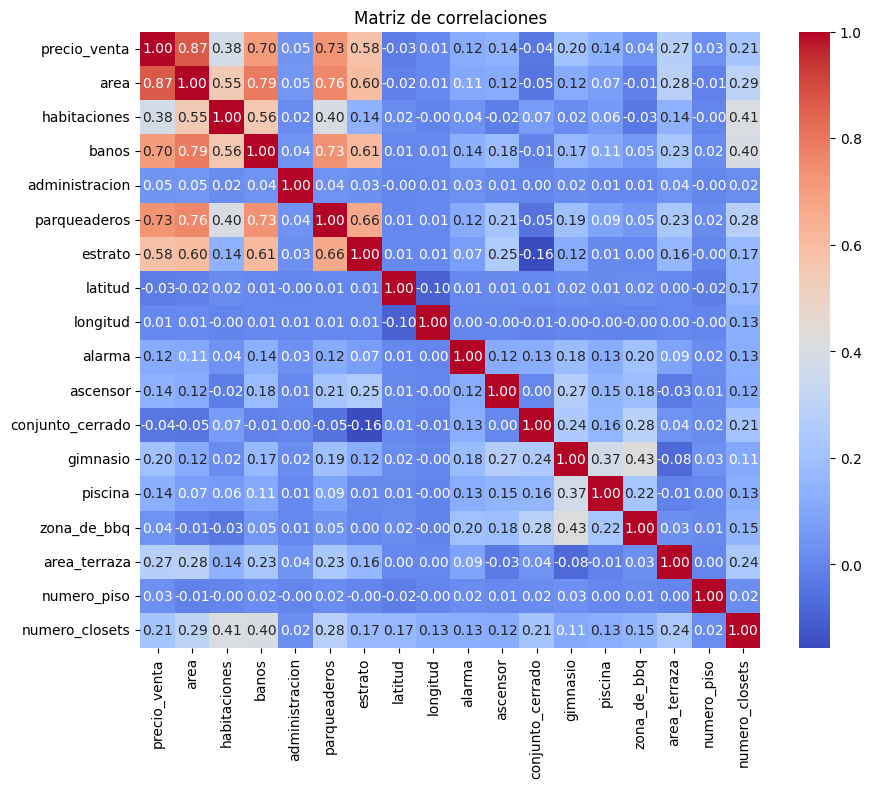

In [ ]:
# --- Correlaciones ---
plt.figure(figsize=(10,8))
sns.heatmap(df_clean.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de correlaciones")
plt.show()


* area, baños, parqueaderos, estrato, administración son las variables más prometedoras para explicar precio_venta.
* La multicolinealidad debe manejarse en el modelo (e.g., PCA, eliminar una de las variables, o usar modelos robustos como árbol de decisión).

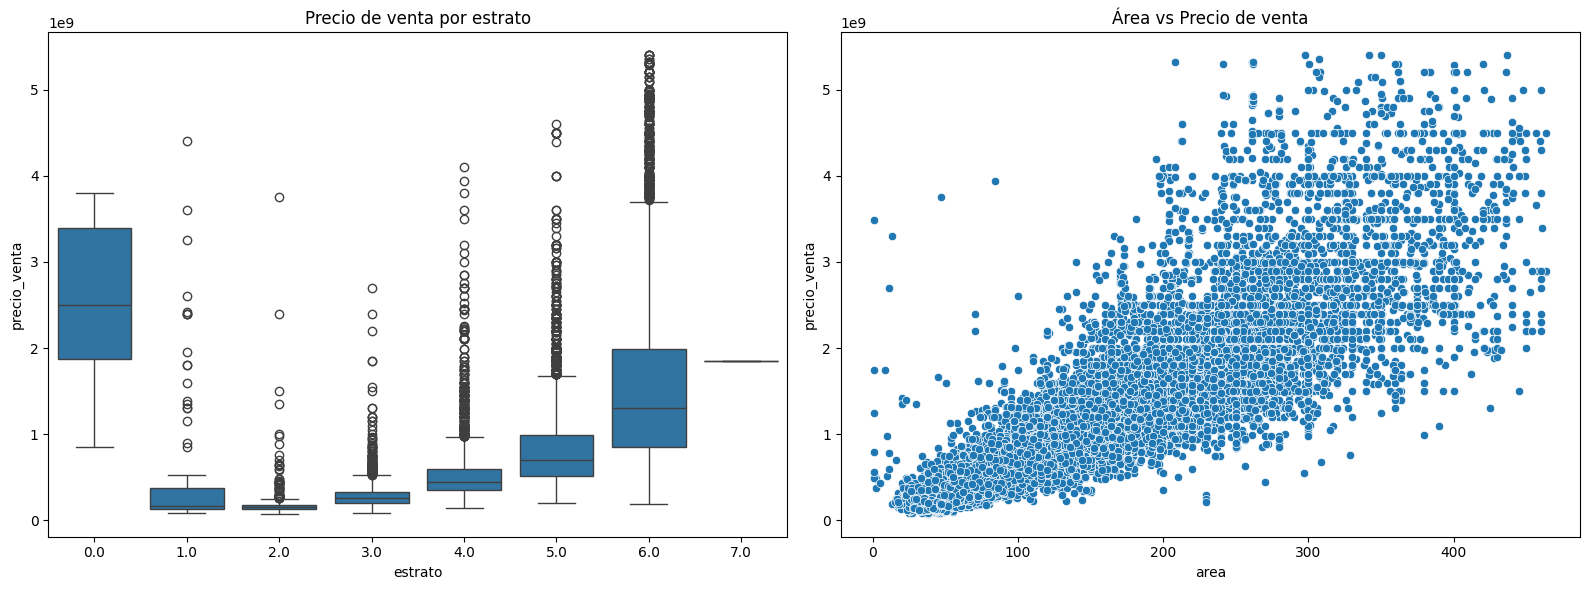

In [ ]:
# --- Relaciones con precio ---
fig, axes = plt.subplots(1, 2, figsize=(16,6))

sns.boxplot(ax=axes[0], x='estrato', y='precio_venta', data=df_clean)
axes[0].set_title("Precio de venta por estrato")

sns.scatterplot(ax=axes[1], x='area', y='precio_venta', data=df_clean)
axes[1].set_title("Área vs Precio de venta")

plt.tight_layout()
plt.show()


<Axes: xlabel='area', ylabel='precio_venta'>

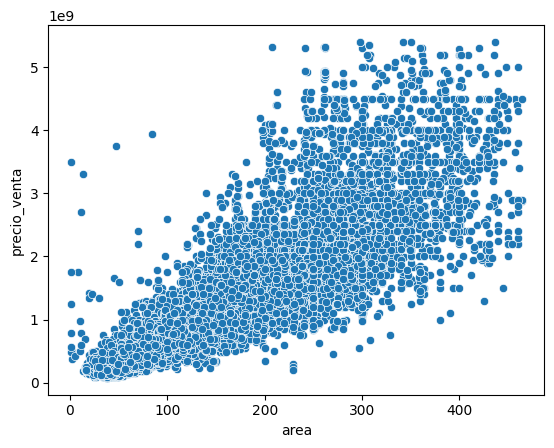

In [ ]:
sns.scatterplot(x='area', y='precio_venta', data=df_clean)

In [ ]:
df_clean.groupby('estrato')['precio_venta'].describe()

,count,mean,std,min,25%,50%,75%,max
estrato,,,,,,,,
0.0,8.0,2.282250e+09,1.205436e+09,5.700000e+08,1.562500e+09,2.225000e+09,3.341000e+09,3.800000e+09
1.0,88.0,5.740440e+08,8.899537e+08,8.300000e+07,1.335000e+08,1.650000e+08,3.507500e+08,4.400000e+09
2.0,954.0,1.841772e+08,1.709414e+08,7.600000e+07,1.340119e+08,1.600000e+08,1.848000e+08,3.750000e+09
3.0,3533.0,2.885168e+08,1.474933e+08,9.000000e+07,1.980000e+08,2.550000e+08,3.300000e+08,2.700000e+09
4.0,5993.0,5.181914e+08,2.925740e+08,1.100000e+06,3.500000e+08,4.500000e+08,5.950000e+08,4.100000e+09
5.0,5570.0,8.403123e+08,4.857817e+08,7.900000e+05,5.200000e+08,7.000000e+08,9.900000e+08,4.600000e+09
6.0,11960.0,1.562778e+09,9.619093e+08,1.000000e+06,8.500000e+08,1.300000e+09,1.980000e+09,5.400000e+09
7.0,1.0,1.850000e+09,NaN,1.850000e+09,1.850000e+09,1.850000e+09,1.850000e+09,1.850000e+09


### Eliminar precios de ventas invalidos

In [ ]:
# Umbral mínimo razonable
umbral_min = 50_000_000  # 50 millones COP

# Filtrar registros con precio_venta por debajo del umbral
invalid_precio = df_clean[df_clean['precio_venta'] < umbral_min]

print(f"Registros con precio_venta < {umbral_min:,}:")
print(f"Total encontrados: {invalid_precio.shape[0]}")

Registros con precio_venta < 50,000,000:
Total encontrados: 56


In [ ]:
# Eliminar registros con precio_venta inválido
df_clean = df_clean[df_clean['precio_venta'] >= umbral_min].reset_index(drop=True)
print(f"Registros eliminados. Dataset limpio ahora tiene {df_clean.shape[0]} filas.")

Registros eliminados. Dataset limpio ahora tiene 28053 filas.


## Imputación de datos

### Área
Para la imputación de datos cuando las áreas son 0 o null se puede calcular el área mediana para propiedades con las mismas características (habitaciones, banos, estrato, sector) y asignar ese valor.

Si no hay suficientes comparables, asigna el área mediana general del mismo estrato.

In [ ]:
print("\nValores de area = 0 o sospechosos:")
print(df_clean[df_clean['area'] <= 0])


Valores de area = 0 o sospechosos:
       precio_venta  area  habitaciones  banos  administracion  parqueaderos  \
2886   7.000000e+08   0.0           3.0    3.0        693400.0           2.0   
8738   2.100000e+09   0.0           3.0    4.0       1200000.0           2.0   
8739   2.680000e+09   0.0           3.0    5.0       1200000.0           4.0   
8742   2.500000e+09   0.0           3.0    5.0       1500000.0           3.0   
8757   3.500000e+09   0.0           4.0    5.0       1800000.0           4.0   
8759   2.500000e+09   0.0           3.0    5.0       2300000.0           3.0   
8792   1.350000e+09   0.0           2.0    3.0        650000.0           2.0   
8799   8.900000e+08   0.0           3.0    5.0        900000.0           2.0   
8802   2.900000e+09   0.0           4.0    5.0       2500000.0           4.0   
9004   2.600000e+08   0.0           1.0    1.0        305000.0           1.0   
9908   3.750000e+09   0.0           5.0    5.0        339000.0           4.0   
1128

In [ ]:
for idx in df_clean[df_clean['area'] == 0].index:
    estrato = df_clean.loc[idx, 'estrato']
    hab = df_clean.loc[idx, 'habitaciones']
    ban = df_clean.loc[idx, 'banos']
    sector = df_clean.loc[idx, 'sector']
    similar = df_clean[
        (df_clean['area'] > 0) &
        (df_clean['estrato'] == estrato) &
        (df_clean['habitaciones'] == hab) &
        (df_clean['banos'] == ban) &
        (df_clean['sector'] == sector)
    ]
    if not similar.empty:
        df_clean.loc[idx, 'area'] = similar['area'].median()
    else:
        df_clean.loc[idx, 'area'] = df_clean[(df_clean['area'] > 0) & (df_clean['estrato'] == estrato)]['area'].median()


In [ ]:
print("\nValores de area = 0 o sospechosos:")
print(df_clean[df_clean['area'] <= 0])


Valores de area = 0 o sospechosos:
Empty DataFrame
Columns: [precio_venta, area, habitaciones, banos, administracion, parqueaderos, sector, estrato, antiguedad, latitud, longitud, estado, alarma, ascensor, conjunto_cerrado, gimnasio, piscina, zona_de_bbq, area_terraza, numero_piso, numero_closets]
Index: []

[0 rows x 21 columns]


### Parqueaderos
Se imputaran por valores basados en la moda del estrato

In [ ]:

print("\nValores de parqueaderos < 0:")
print(df_clean[df_clean['parqueaderos'] < 0])


Valores de parqueaderos < 0:
     precio_venta  area  habitaciones  banos  administracion  parqueaderos  \
269   307169231.0  67.0           3.0    2.0        278000.0          -2.0   

       sector  estrato        antiguedad   latitud  ...  estado alarma  \
269  RESTREPO      3.0  ENTRE 0 Y 5 ANOS  4.589682  ...     NaN      0   

     ascensor  conjunto_cerrado  gimnasio  piscina  zona_de_bbq  area_terraza  \
269         0                 1         0        0            0           NaN   

     numero_piso  numero_closets  
269          NaN             NaN  

[1 rows x 21 columns]


In [ ]:
# Filtrar el índice del registro con parqueaderos < 0
idx_neg = df_clean[df_clean['parqueaderos'] < 0].index

for idx in idx_neg:
    estrato = df_clean.loc[idx, 'estrato']
    
    # calcular la moda en el mismo estrato
    moda_parq = (
        df_clean[(df_clean['parqueaderos'] >= 0) & (df_clean['estrato'] == estrato)]['parqueaderos']
        .mode()
    )
    
    # si no hay moda en ese estrato (muy raro), usa moda general
    if not moda_parq.empty:
        df_clean.loc[idx, 'parqueaderos'] = moda_parq[0]
    else:
        df_clean.loc[idx, 'parqueaderos'] = df_clean[df_clean['parqueaderos'] >= 0]['parqueaderos'].mode()[0]

print(f"Reemplazado parqueaderos < 0 por la moda del mismo estrato.")

Reemplazado parqueaderos < 0 por la moda del mismo estrato.


In [ ]:
print("\nValores de parqueaderos < 0:")
print(df_clean[df_clean['parqueaderos'] < 0])


Valores de parqueaderos < 0:
Empty DataFrame
Columns: [precio_venta, area, habitaciones, banos, administracion, parqueaderos, sector, estrato, antiguedad, latitud, longitud, estado, alarma, ascensor, conjunto_cerrado, gimnasio, piscina, zona_de_bbq, area_terraza, numero_piso, numero_closets]
Index: []

[0 rows x 21 columns]


### Coordenadas

In [ ]:
print("\nCoordenadas fuera de Bogotá:")
print(df_clean[(df_clean['latitud'] < 4) | (df_clean['latitud'] > 5) | (df_clean['longitud'] > -73) | (df_clean['longitud'] < -75)])


Coordenadas fuera de Bogotá:
       precio_venta    area  habitaciones  banos  administracion  \
1938   2.100000e+08   40.50           2.0    1.0             NaN   
4482   5.400000e+08  124.47           4.0    3.0        598100.0   
5881   3.300000e+09  390.00           4.0    5.0       2000000.0   
8345   9.100000e+08  172.00           3.0    3.0             NaN   
9319   2.600000e+09  316.00           3.0    4.0       2045000.0   
11526  2.200000e+09  299.00           4.0    5.0       2064000.0   
14666  2.680000e+09  324.00           3.0    4.0             NaN   
14790  5.500000e+08  117.00           2.0    2.0        380000.0   
15338  2.390000e+09  370.00           4.0    5.0             NaN   
15648  1.300000e+09  161.00           3.0    3.0       1000000.0   
16791  4.600000e+08   93.00           3.0    2.0        450000.0   
16973  7.330000e+08   70.30           1.0    2.0        800000.0   
20034  4.400000e+08   67.00           3.0    2.0        385000.0   
22677  1.130000e+0

In [ ]:
invalid_coords = (df_clean['latitud'] < 4) | (df_clean['latitud'] > 5) | (df_clean['longitud'] < -75) | (df_clean['longitud'] > -73)
for idx in df_clean[invalid_coords].index:
    sector = df_clean.loc[idx, 'sector']
    if pd.notnull(sector):
        df_clean.loc[idx, 'latitud'] = df_clean[df_clean['sector'] == sector]['latitud'].median()
        df_clean.loc[idx, 'longitud'] = df_clean[df_clean['sector'] == sector]['longitud'].median()
    else:
        df_clean.loc[idx, 'latitud'] = df_clean['latitud'].median()
        df_clean.loc[idx, 'longitud'] = df_clean['longitud'].median()

In [ ]:
print("\nCoordenadas fuera de Bogotá:")
print(df_clean[(df_clean['latitud'] < 4) | (df_clean['latitud'] > 5) | (df_clean['longitud'] > -73) | (df_clean['longitud'] < -75)])


Coordenadas fuera de Bogotá:
Empty DataFrame
Columns: [precio_venta, area, habitaciones, banos, administracion, parqueaderos, sector, estrato, antiguedad, latitud, longitud, estado, alarma, ascensor, conjunto_cerrado, gimnasio, piscina, zona_de_bbq, area_terraza, numero_piso, numero_closets]
Index: []

[0 rows x 21 columns]


In [ ]:
valid_lat = df_clean['latitud'].between(4.4, 4.9)
valid_lon = df_clean['longitud'].between(-74.3, -73.9)

# Contar antes
invalid_count = df_clean[~(valid_lat & valid_lon)].shape[0]
print(f"Registros con coordenadas inválidas: {invalid_count}")

# Filtrar
df_clean = df_clean[valid_lat & valid_lon].reset_index(drop=True)

print(f"Registros eliminados. Dataset ahora tiene {df_clean.shape[0]} filas.")

Registros con coordenadas inválidas: 684
Registros eliminados. Dataset ahora tiene 27369 filas.


In [ ]:
# --- Distribución espacial ---
if df_clean['latitud'].notnull().all() and df_clean['longitud'].notnull().all():
    fig = px.scatter_mapbox(
        df_clean,
        lat='latitud',
        lon='longitud',
        color='precio_venta',
        size='area',
        color_continuous_scale='Viridis',
        mapbox_style='carto-positron',
        zoom=10,
        title="Mapa: ubicación de propiedades",
        height=900
    )
    fig.show()
else:
    print("\nHay coordenadas nulas o fuera de rango, revisar antes de mapear.")

/tmp/ipykernel_216801/2798087819.py:3: DeprecationWarning: *scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/
  fig = px.scatter_mapbox(


### Estrato

In [ ]:
print("\nValores de estrato fuera de rango (1–6):")
print(df_clean[(df_clean['estrato'] < 1) | (df['estrato'] > 6)])


Valores de estrato fuera de rango (1–6):
       precio_venta   area  habitaciones  banos  administracion  parqueaderos  \
3641   1.800000e+09  320.0           4.0    4.0       1600000.0           4.0   
4330   3.800000e+09  400.0           4.0    5.0       2500000.0           3.0   
5348   4.700000e+08   65.0           2.0    2.0        480000.0           1.0   
8757   2.500000e+09  273.0           4.0    5.0        800000.0           3.0   
8928   3.288000e+09  266.0           3.0    5.0       1300000.0           3.0   
11776  1.950000e+09  176.0           3.0    3.0             NaN           3.0   
25324  8.500000e+08  108.0           2.0    3.0        480000.0           2.0   
26008  3.500000e+09  317.0           4.0    4.0       2306000.0           4.0   

                sector  estrato          antiguedad   latitud  ...  estado  \
3641     SANTA BARBARA      0.0  ENTRE 10 Y 20 ANOS  4.692737  ...   USADO   
4330             CHICO      0.0          REMODELADO  4.664496  ...   USA

/tmp/ipykernel_216801/3387050430.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [ ]:
# Intentamos imputar la mayor cantidad de elementos de estrato basandonos en el sector, si no es posible entonces no se eliminan ya que esto se puede calcular
# luego.

for idx in df[(df['estrato'] < 1) | (df['estrato'] > 6)].index:
    sector = df.loc[idx, 'sector']
    if pd.notnull(sector):
        df.loc[idx, 'estrato'] = df[(df['sector'] == sector) & (df['estrato'].between(1,6))]['estrato'].mode()[0]
    else:
        df.loc[idx, 'estrato'] = df[df['estrato'].between(1,6)]['estrato'].mode()[0]


In [ ]:
print("\nValores de estrato fuera de rango (1–6):")
print(df_clean[(df_clean['estrato'] < 1) | (df['estrato'] > 6)])


Valores de estrato fuera de rango (1–6):
       precio_venta   area  habitaciones  banos  administracion  parqueaderos  \
3641   1.800000e+09  320.0           4.0    4.0       1600000.0           4.0   
4330   3.800000e+09  400.0           4.0    5.0       2500000.0           3.0   
8757   2.500000e+09  273.0           4.0    5.0        800000.0           3.0   
8928   3.288000e+09  266.0           3.0    5.0       1300000.0           3.0   
11776  1.950000e+09  176.0           3.0    3.0             NaN           3.0   
25324  8.500000e+08  108.0           2.0    3.0        480000.0           2.0   
26008  3.500000e+09  317.0           4.0    4.0       2306000.0           4.0   

                sector  estrato          antiguedad   latitud  ...  estado  \
3641     SANTA BARBARA      0.0  ENTRE 10 Y 20 ANOS  4.692737  ...   USADO   
4330             CHICO      0.0          REMODELADO  4.664496  ...   USADO   
8757   SALITRE MODELIA      0.0   ENTRE 5 Y 10 ANOS  4.651504  ...   USADO 

/tmp/ipykernel_216801/3387050430.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [ ]:
cols_enteros = ["precio_venta", "habitaciones", "banos", "administracion", 
                "parqueaderos", "estrato", "area_terraza", "numero_piso", "numero_closets"]

print(f"Columnas candidatas a int: {cols_enteros}")
print("-" * 50)
int_cols = []
# revisar NaNs
for col in cols_enteros:
    n_nulos = df_clean[col].isna().sum()
    n_total = len(df_clean)
    if n_nulos > 0:
        print(f"{col}: {n_nulos} NaN ({n_nulos/n_total:.1%})")
    else:
        int_cols.append(col)
        print(f"{col}: sin NaN")

Columnas candidatas a int: ['precio_venta', 'habitaciones', 'banos', 'administracion', 'parqueaderos', 'estrato', 'area_terraza', 'numero_piso', 'numero_closets']
--------------------------------------------------
precio_venta: sin NaN
habitaciones: sin NaN
banos: sin NaN
administracion: 2399 NaN (8.8%)
parqueaderos: sin NaN
estrato: 2 NaN (0.0%)
area_terraza: 20450 NaN (74.7%)
numero_piso: 8829 NaN (32.3%)
numero_closets: 17296 NaN (63.2%)


In [ ]:
for col in int_cols:
    print("convirtiendo a int:", col)
    # Si tienes valores nulos en la columna, usa Int64 para soportar NaN
    df[col] = df[col].astype(int)

convirtiendo a int: precio_venta
convirtiendo a int: habitaciones
convirtiendo a int: banos
convirtiendo a int: parqueaderos


## Recomendaciones (transformación y entrenamiento):

* En el modelado, considerar aplicar logaritmo a precio_venta y/o area para reducir asimetría y mejorar linealidad.



In [ ]:
def export_dataframe(df: pd.DataFrame, suffix: str):
    file_name = f"aptos_bogota_{suffix}.csv"
    sample_file_name = f"aptos_bogota_{suffix}_sample.csv"
    df.to_csv(f"{data_dir}/{file_name}", index=False)
    df = df.sample(n=50, random_state=42)
    df.to_csv(f"{data_dir}/{sample_file_name}", index=False)
    print(f"Archivo '{file_name}' exportado correctamente.")

export_dataframe(df_clean, "cleaned")

Archivo 'aptos_bogota_cleaned.csv' exportado correctamente.


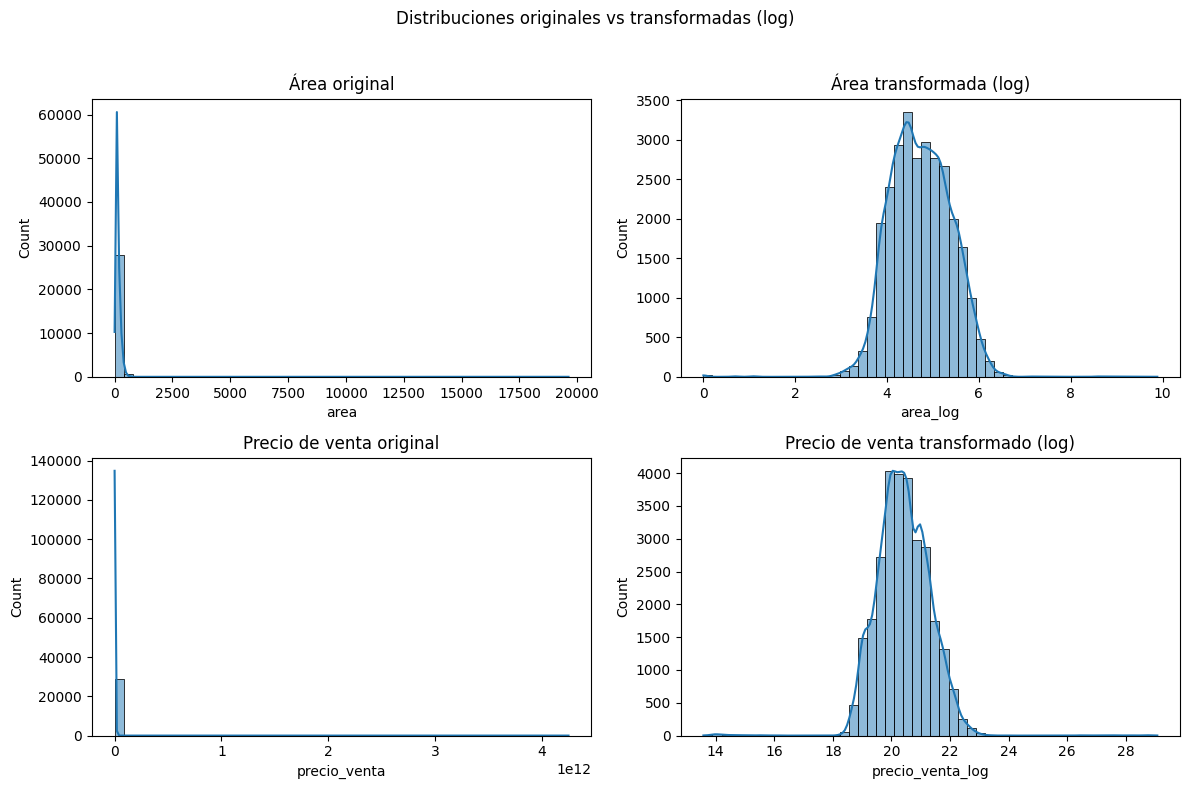

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Crear copia del dataset y agregar columnas transformadas
df_log = df.copy()
df_log["area_log"] = np.log1p(df_log["area"])
df_log["precio_venta_log"] = np.log1p(df_log["precio_venta"])

# Configurar figura
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plt.suptitle("Distribuciones originales vs transformadas (log)")

# Área
sns.histplot(df["area"], bins=50, kde=True, ax=axes[0,0])
axes[0,0].set_title("Área original")
sns.histplot(df_log["area_log"], bins=50, kde=True, ax=axes[0,1])
axes[0,1].set_title("Área transformada (log)")

# Precio de venta
sns.histplot(df["precio_venta"], bins=50, kde=True, ax=axes[1,0])
axes[1,0].set_title("Precio de venta original")
sns.histplot(df_log["precio_venta_log"], bins=50, kde=True, ax=axes[1,1])
axes[1,1].set_title("Precio de venta transformado (log)")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Imputación de datos

En este segmento se van a imputar algunos datos para tenerlos más listos para los siguientes pasos, sin embargo se guardarán en un archivo distinto para tener el dataset original también disponible.

In [ ]:
df = df_clean.copy()


def reporte_nulos():
    nulos_previos = df.isna().sum()
    nulos_previos = nulos_previos[nulos_previos > 0]
    total_filas = len(df)

    print("Reporte de valores nulos:")
    for col, n in nulos_previos.items():
        print(f"- {col}: {n} nulos ({(n / total_filas) * 100:.2f}%)")

reporte_nulos()


Reporte de valores nulos:
- administracion: 2399 nulos (8.77%)
- sector: 775 nulos (2.83%)
- estrato: 2 nulos (0.01%)
- antiguedad: 10 nulos (0.04%)
- estado: 743 nulos (2.71%)
- area_terraza: 20450 nulos (74.72%)
- numero_piso: 8829 nulos (32.26%)
- numero_closets: 17296 nulos (63.20%)


Hay bastantes datos sin precio de administración, teniendo en cuenta que la admon se debe pagar siempre, es probable que este valor esté incluído en el precio del arriendo o simplemente se haya olvidado al reportarlo, lo que se hará es imputarlo pero además se dejará una marca indicando que el valor fue imputado.

In [ ]:
# imputación de administración
df['administracion_imputada'] = df['administracion'].isna().astype(int)

# Imputar con promedio por sector
df['administracion'] = df.groupby('sector')['administracion'].transform(
    lambda x: x.fillna(x.mean())
)
# Imputar con promedio por estrato
df['administracion'] = df.groupby('estrato')['administracion'].transform(lambda x: x.fillna(x.mean()))


columnas_con_nulos = df.columns[df.isna().any()].tolist()

reporte_nulos()

Reporte de valores nulos:
- administracion: 2 nulos (0.01%)
- sector: 775 nulos (2.83%)
- estrato: 2 nulos (0.01%)
- antiguedad: 10 nulos (0.04%)
- estado: 743 nulos (2.71%)
- area_terraza: 20450 nulos (74.72%)
- numero_piso: 8829 nulos (32.26%)
- numero_closets: 17296 nulos (63.20%)


In [ ]:
# imputacion de estrato
# Marcar si fue imputado
df['estrato_imputado'] = df['estrato'].isna().astype(int)
# Imputar con moda del sector
df['estrato'] = df.groupby('sector')['estrato'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x)
reporte_nulos()

Reporte de valores nulos:
- administracion: 2 nulos (0.01%)
- sector: 775 nulos (2.83%)
- estrato: 775 nulos (2.83%)
- antiguedad: 10 nulos (0.04%)
- estado: 743 nulos (2.71%)
- area_terraza: 20450 nulos (74.72%)
- numero_piso: 8829 nulos (32.26%)
- numero_closets: 17296 nulos (63.20%)


In [ ]:
export_dataframe(df, "imputed")

Archivo 'aptos_bogota_imputed.csv' exportado correctamente.


## Imputación enriquecida
Esta imputación implica obtener la columna sector a partir de geocodificación, para esto se usará la tabla de upz de los mapas de Bogotá, ya que puede brindar una sectorización más detallada.